---
# **Assignment 2 for Clustering: Sessa Empirical Estimator**  
---

$\textbf{R code - Python Code}$

- $\textbf{Using the Med.Events dataset}$

In [23]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score



# Step 1: Load & Preprocess Data
file_path = "med_events.csv"
df = pd.read_csv(file_path)

df.rename(columns={
    "PATIENT_ID": "pnr",    # Patient ID
    "DATE": "eksd",         # Prescription date
    "PERDAY": "perday",     # Daily dosage
    "CATEGORY": "ATC",      # Drug type
    "DURATION": "dur_original"  # Prescription duration
}, inplace=True)

df["eksd"] = pd.to_datetime(df["eksd"], format="%m/%d/%Y")
df = df.sort_values(by=["pnr", "eksd"])

# Step 1.5: Filter Data for a Specific Drug
selected_drug = "medA"  # Change this to "medB" or another drug
df = df[df["ATC"] == selected_drug]

# Step 2: Compute Event Intervals
df["prev_eksd"] = df.groupby("pnr")["eksd"].shift(1)
df["event.interval"] = (df["eksd"] - df["prev_eksd"]).dt.days
df = df.dropna(subset=["event.interval"])

# Step 2.5: Randomly Select One Prescription Per Patient
df_filtered = df.groupby("pnr").apply(lambda x: x.sample(n=min(1, len(x)), random_state=42)).reset_index(drop=True)

df.head()

C:\Users\Michael\AppData\Local\Temp\ipykernel_12000\2935975073.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df.groupby("pnr").apply(lambda x: x.sample(n=min(1, len(x)), random_state=42)).reset_index(drop=True)


,pnr,eksd,perday,ATC,dur_original,prev_eksd,event.interval
25,2,2036-03-10,4,medA,50,2036-01-20,50.0
26,2,2036-08-01,4,medA,50,2036-03-10,144.0
61,4,2032-11-27,4,medA,50,2032-05-01,210.0
62,4,2033-08-20,4,medA,50,2032-11-27,266.0
63,4,2033-08-30,4,medA,50,2033-08-20,10.0


$\textbf{ II. Generating the Emperical CDF and filtering the top 20 percent}$ 

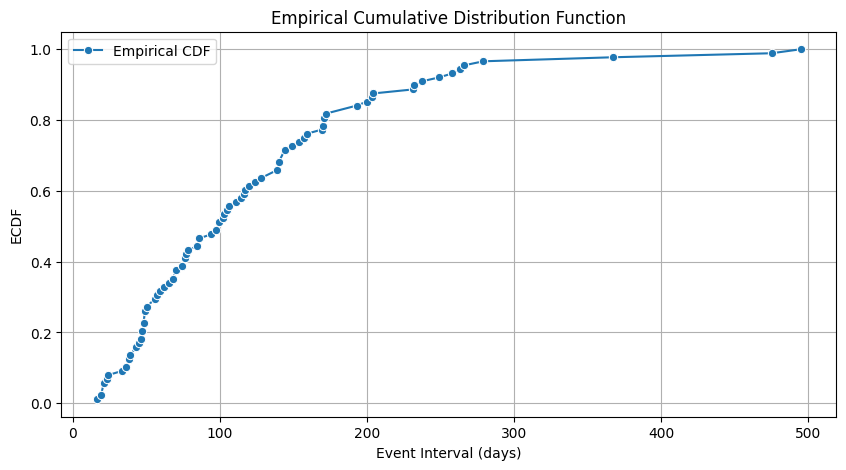

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event.interval,Cluster
0,2,2036-08-01,4,medA,50,2036-03-10,144.0,1
2,5,2031-12-27,8,medA,30,2031-10-26,62.0,7
3,6,2037-03-24,4,medA,50,2037-01-07,76.0,2
5,8,2034-07-17,6,medA,50,2034-06-28,19.0,0
6,9,2032-08-18,2,medA,50,2032-03-01,170.0,5


In [24]:
# Step 3: Generate ECDF & Remove Top 20%
event_intervals = df_filtered["event.interval"].dropna()
ecdf = ECDF(event_intervals)
x = np.sort(event_intervals)
y = ecdf(x)

plt.figure(figsize=(10, 5))
sns.lineplot(x=x, y=y, marker="o", label="Empirical CDF")
plt.xlabel("Event Interval (days)")
plt.ylabel("ECDF")
plt.title("Empirical Cumulative Distribution Function")
plt.grid()
plt.show()

threshold = np.percentile(event_intervals, 80)  # 80th percentile cutoff
df_filtered = df_filtered[df_filtered["event.interval"] <= threshold].copy()
df_filtered["Cluster"] = kmeans.predict(scaler.transform(df_filtered[["event.interval"]]))


df_filtered.head()

$\textbf{ III. Applying K-means clustering}$ 

In [25]:
# Step 4: Apply K-Means Clustering
X = df_filtered[["event.interval"]] 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sil_scores = []
cluster_range = range(2, 10)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, algorithm="elkan", random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

optimal_k = cluster_range[np.argmax(sil_scores)]
kmeans_final = KMeans(n_clusters=optimal_k, algorithm="elkan", random_state=42, n_init=10)
df_filtered["Cluster"] = kmeans_final.fit_predict(X_scaled)

df_filtered.head()


,pnr,eksd,perday,ATC,dur_original,prev_eksd,event.interval,Cluster
0,2,2036-08-01,4,medA,50,2036-03-10,144.0,1
2,5,2031-12-27,8,medA,30,2031-10-26,62.0,0
3,6,2037-03-24,4,medA,50,2037-01-07,76.0,0
5,8,2034-07-17,6,medA,50,2034-06-28,19.0,0
6,9,2032-08-18,2,medA,50,2032-03-01,170.0,1


$\textbf{ IV. Assigning Cluster Statistics}$ 

In [26]:
# Step 5: Compute Cluster Statistics
ni2 = df_filtered.groupby("Cluster")["event.interval"].min()
ni3 = df_filtered.groupby("Cluster")["event.interval"].max()
ni4 = df_filtered.groupby("Cluster")["event.interval"].median()

cluster_stats = pd.DataFrame({
    "Cluster": ni2.index,
    "Minimum": ni2.values,
    "Maximum": ni3.values,
    "Median": ni4.values
})
cluster_stats = cluster_stats[cluster_stats["Median"] > 0]

# Step 6: Assign Patients to Clusters
results = df.merge(df_filtered[["pnr", "Cluster"]], on="pnr", how="left")

# Now merge with cluster statistics to get Minimum, Maximum, and Median values
results = results.merge(cluster_stats, on="Cluster", how="left")
results = results[(results["event.interval"] >= results["Minimum"]) & 
                  (results["event.interval"] <= results["Maximum"])]
results.dropna(subset=["Cluster"], inplace=True)

results.head()

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event.interval,Cluster,Minimum,Maximum,Median
1,2,2036-08-01,4,medA,50,2036-03-10,144.0,1.0,94.0,171.0,133.5
6,5,2031-12-27,8,medA,30,2031-10-26,62.0,0.0,16.0,86.0,49.0
7,5,2032-01-25,8,medA,30,2031-12-27,29.0,0.0,16.0,86.0,49.0
8,5,2032-03-04,8,medA,30,2032-01-25,39.0,0.0,16.0,86.0,49.0
12,6,2037-03-24,4,medA,50,2037-01-07,76.0,0.0,16.0,86.0,49.0


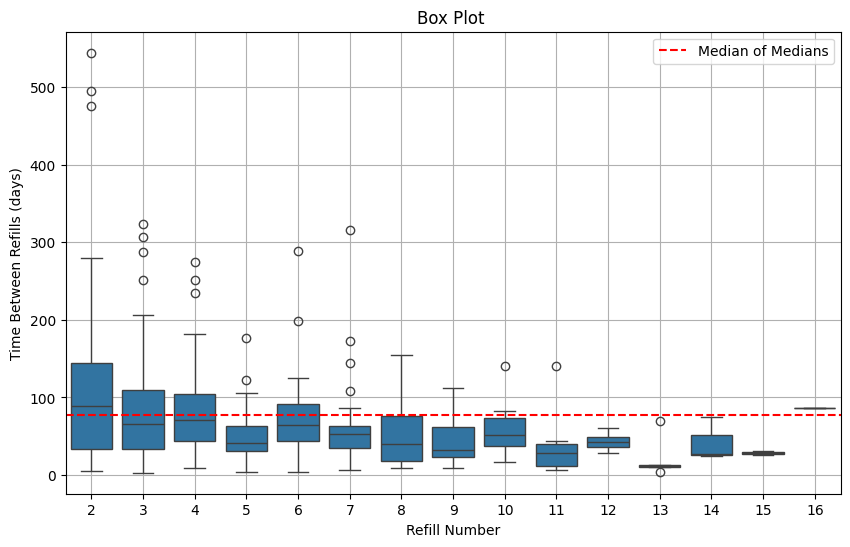

In [27]:
# Step 7: SEE Assumption Check (Whisker Plot)

# Compute refill sequence number (p_number) per patient
df["p_number"] = df.groupby("pnr").cumcount() + 1

# Filter to remove first refill, as done in R script (only p_number >= 2)
df_filtered = df[df["p_number"] >= 2].copy()

# Compute median of medians per patient
medians_of_medians = df_filtered.groupby("pnr")["event.interval"].median().median()

plt.figure(figsize=(10, 6))
sns.boxplot(x="p_number", y="event.interval", data=df_filtered)

# Add median of medians as reference line
plt.axhline(y=medians_of_medians, linestyle="dashed", color="red", label="Median of Medians")

plt.xlabel("Refill Number")
plt.ylabel("Time Between Refills (days)")
plt.title("Box Plot ")
plt.legend()
plt.grid()
plt.show()


C:\Users\Michael\AppData\Local\Temp\ipykernel_12000\1914855216.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["eksd"] = pd.to_datetime(df["eksd"], errors='coerce')
C:\Users\Michael\AppData\Local\Temp\ipykernel_12000\1914855216.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = data.groupby('pnr').apply(lambda x: x.sample(1, random_state=1234)).reset_index(drop=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_12000\1914855216.py:53: FutureWarning: The provided callable <function min at 0x0000022E7E6F27A0> is currently using SeriesGroupB

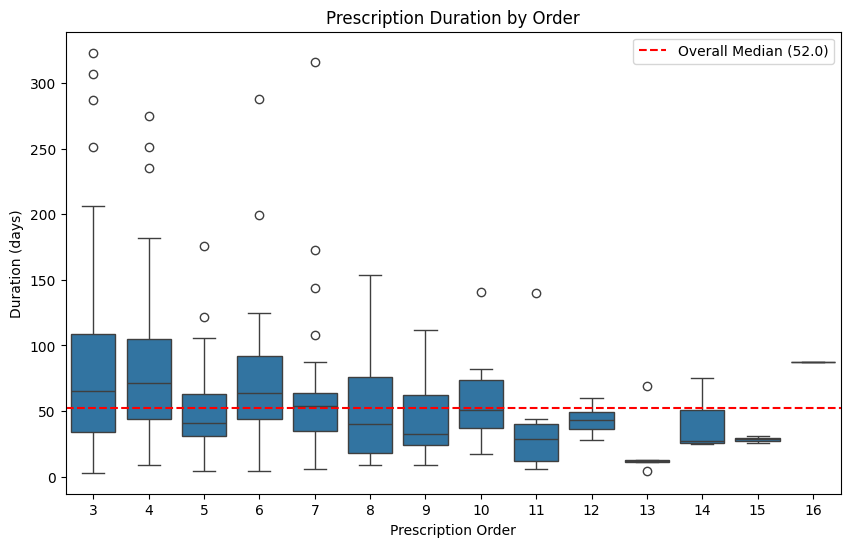

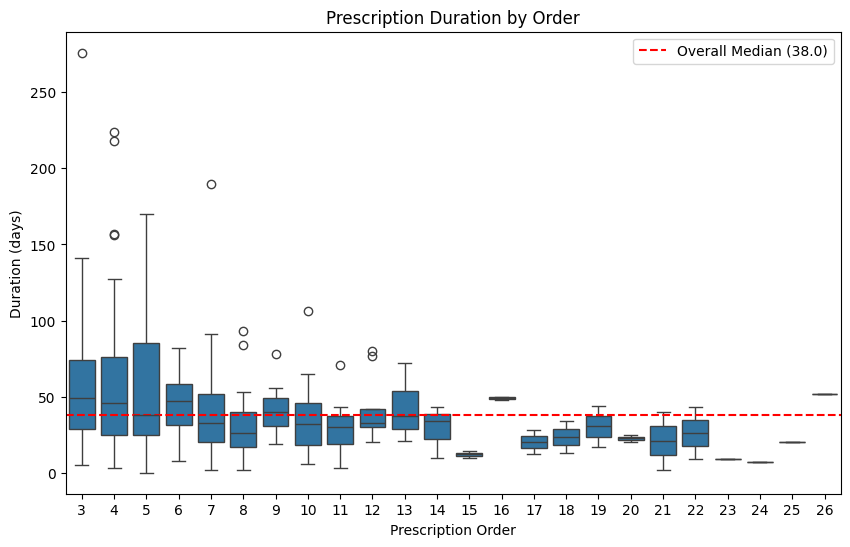

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
import random

df["eksd"] = pd.to_datetime(df["eksd"], errors='coerce')




def see(drug_code, df):
    data = df[df['ATC'] == drug_code].copy()
    data.sort_values(by=['pnr', 'eksd'], inplace=True)
    data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
    data = data.dropna(subset=['prev_eksd']).copy()
    sampled = data.groupby('pnr').apply(lambda x: x.sample(1, random_state=1234)).reset_index(drop=True)
    sampled = sampled[['pnr', 'eksd', 'prev_eksd']].copy()
    sampled['event_interval'] = (sampled['eksd'] - sampled['prev_eksd']).dt.days.astype(float)
    sorted_intervals = np.sort(sampled['event_interval'])
    n = len(sorted_intervals)
    ecdf_y = np.arange(1, n + 1) / n
    df_ecdf = pd.DataFrame({'x': sorted_intervals, 'y': ecdf_y})
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8]
    threshold = df_ecdf_80['x'].max() if not df_ecdf_80.empty else np.percentile(sampled['event_interval'], 80)
    filtered_intervals = sampled[sampled['event_interval'] <= threshold]['event_interval']
    log_intervals = np.log(filtered_intervals[filtered_intervals > 0])
    kde = gaussian_kde(log_intervals)
    grid = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    density = kde(grid)
    density_data = np.vstack([grid, density]).T
    scaler = StandardScaler()
    scaled_density = scaler.fit_transform(density_data)
    best_score = -1
    best_k = 2
    for k in range(2, min(10, len(scaled_density))):
        kmeans = KMeans(n_clusters=k, random_state=1234)
        labels = kmeans.fit_predict(scaled_density)
        score = silhouette_score(scaled_density, labels)
        if score > best_score:
            best_score = score
            best_k = k
    df_ecdf_nonzero = df_ecdf[df_ecdf['x'] > 0].copy().reset_index(drop=True)
    df_ecdf_nonzero['log_x'] = np.log(df_ecdf_nonzero['x'])
    X_cluster = df_ecdf_nonzero['log_x'].values.reshape(-1,1)
    kmeans_final = KMeans(n_clusters=best_k, random_state=1234)
    cluster_labels = kmeans_final.fit_predict(X_cluster)
    df_ecdf_nonzero['cluster'] = cluster_labels
    cluster_bounds = df_ecdf_nonzero.groupby('cluster')['log_x'].agg([np.min, np.max, np.median]).reset_index()
    cluster_bounds['min_exp'] = np.exp(cluster_bounds['min'])
    cluster_bounds['max_exp'] = np.exp(cluster_bounds['max'])
    cluster_bounds['median_exp'] = np.exp(cluster_bounds['median'])
    
    def assign_cluster(interval):
        log_int = np.log(interval) if interval > 0 else -np.inf
        for _, row in cluster_bounds.iterrows():
            if row['min'] <= log_int <= row['max']:
                return pd.Series([int(row['cluster']), row['median_exp']])
        default_median = np.exp(cluster_bounds['median'].min())
        return pd.Series([0, default_median])
    
    sampled[['Final_cluster', 'Median']] = sampled['event_interval'].apply(assign_cluster)
    final_data = pd.merge(data, sampled[['pnr','Median','Final_cluster']], on='pnr', how='left')
    overall_median = cluster_bounds['median_exp'].median()
    final_data['Median'] = final_data['Median'].fillna(overall_median)
    final_data['Final_cluster'] = final_data['Final_cluster'].fillna(0).astype(int)
    return final_data

def see_assumption(data):
    data = data.sort_values(by=['pnr', 'eksd']).copy()
    data['p_number'] = data.groupby('pnr').cumcount() + 1
    data_assumption = data[data['p_number'] >= 2].copy()
    data_assumption['prev_eksd'] = data_assumption.groupby('pnr')['eksd'].shift(1)
    data_assumption = data_assumption.dropna(subset=['prev_eksd'])
    data_assumption['Duration'] = (data_assumption['eksd'] - data_assumption['prev_eksd']).dt.days
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=data_assumption)
    overall_median = data_assumption['Duration'].median()
    plt.axhline(overall_median, color='red', linestyle='--', label=f'Overall Median ({overall_median:.1f})')
    plt.title('Prescription Duration by Order')
    plt.xlabel('Prescription Order')
    plt.ylabel('Duration (days)')
    plt.legend()
    plt.show()

medA = see("medA", df)
medB = see("medB", df)
see_assumption(medA)
see_assumption(medB)
